Develop an analysis with sections.

In [1]:
#essential imports
import os
import numpy as np
import pandas as pd
from dmt.model.interface import Interface
from dmt.tk.phenomenon import Phenomenon
from dmt.tk.plotting import Bars
from dmt.tk.plotting.multi import MultiPlot
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.composition\
    import CompositionAnalysesSuite
from neuro_dmt.models.bluebrain.circuit.atlas import\
    BlueBrainCircuitAtlas
from neuro_dmt.models.bluebrain.circuit.model import\
    BlueBrainCircuitModel
from neuro_dmt.analysis.reporting import\
    CircuitProvenance,\
    CircuitAnalysisReport
from neuro_dmt.models.bluebrain.circuit.adapter import\
    BlueBrainCircuitAdapter
from neuro_dmt.analysis.reporting import CheetahReporter

In [2]:
#paths
project =\
    os.path.join(
        "/gpfs/bbp.cscs.ch/project")
proj_sscx_diss=\
    os.path.join(
        project,
        "proj83")
data_sscx_diss=\
    os.path.join(
        proj_sscx_diss,
        "data")
atlases_sscx_diss=\
    os.path.join(
        data_sscx_diss,
        "atlas/S1/MEAN")
circuits_sscx_diss=\
    os.path.join(
        proj_sscx_diss,
        "circuits")
atlas_bio_m =\
    BlueBrainCircuitAtlas(
        path=os.path.join(
                atlases_sscx_diss, "P14-MEAN"))
path_bio_m =\
    os.path.join(
        circuits_sscx_diss,
        "Bio_M/20191206")
circuit_bio_m =\
    BlueBrainCircuitModel(
        path_circuit_data=path_bio_m,
        provenance=CircuitProvenance(
            label="SSCxRatDisseminationBioM",
            authors=["BBP Team"],
            date_release="20191212",
            uri=path_bio_m,
            animal="Wistar Rat",
            age="P14 Weeks",
            brain_region="SSCx"))
adapter =\
    BlueBrainCircuitAdapter()

In [3]:
from dmt.analysis.sectioned import *

In [4]:
def get_cell_density(adapter, circuit_model):
    """
    Get cell density in `circuit_model` for each region and layer.
    """
    raise NotImplementedError

In [5]:
class AdapterInterface(Interface):
    """Just a dummy"""
    def get_cell_density(self, model, **query):
        raise NotImplementedError
        
    def get_label(self, model):
        """A label for the model"""
        raise NotImplementedError
        
class MockAdapter:
    def get_label(self, model):
        return "Model"
    
    def get_provenance(self, model):
        return CircuitProvenance().field_dict
    
    def get_cell_density(self, model, **query):
        return np.random.uniform(0., 1.e4)
    
    
adapter = MockAdapter()
    
    
class MockModel:
    pass

model = MockModel()

24it [00:00, 708.23it/s]


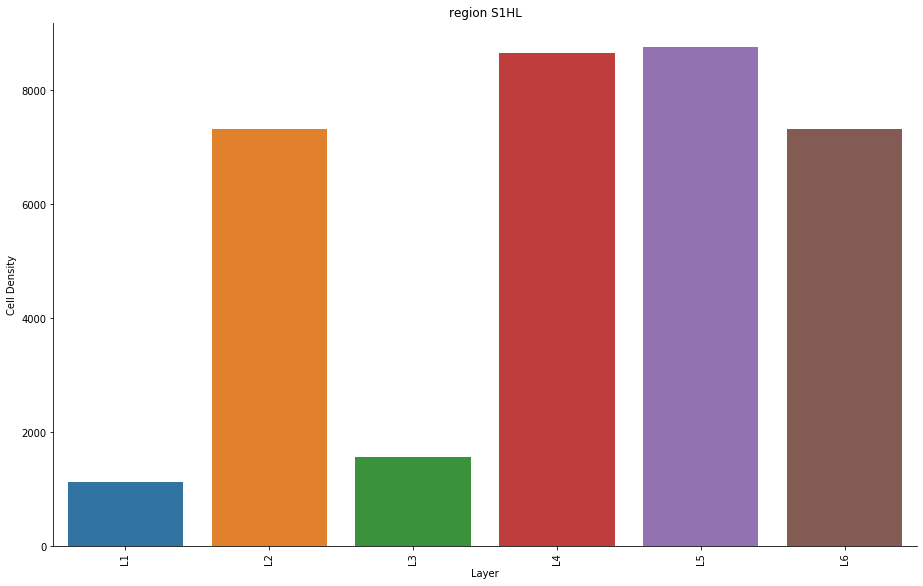

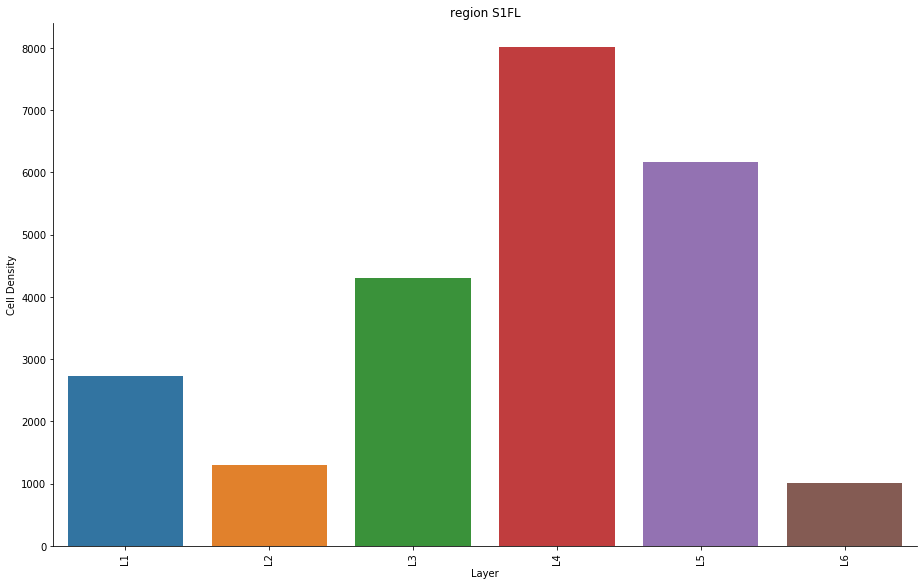

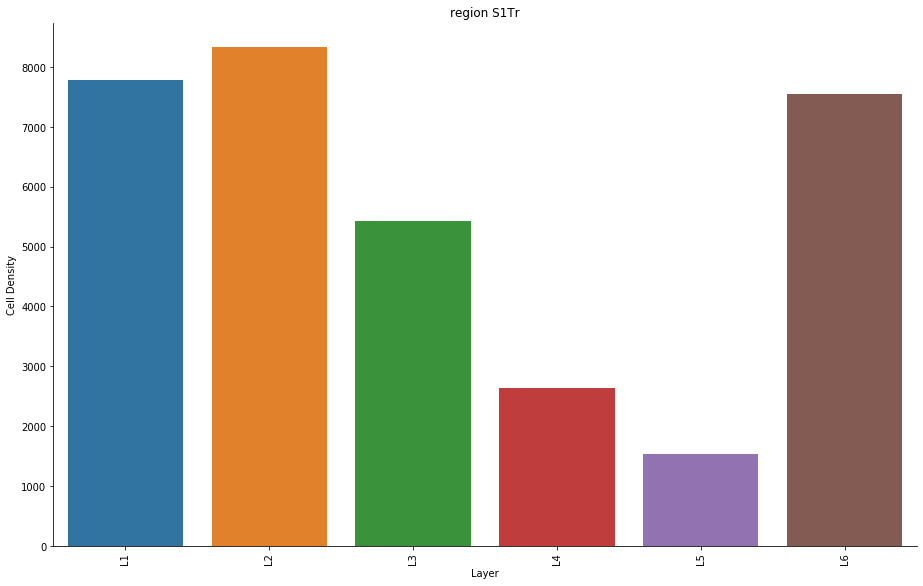

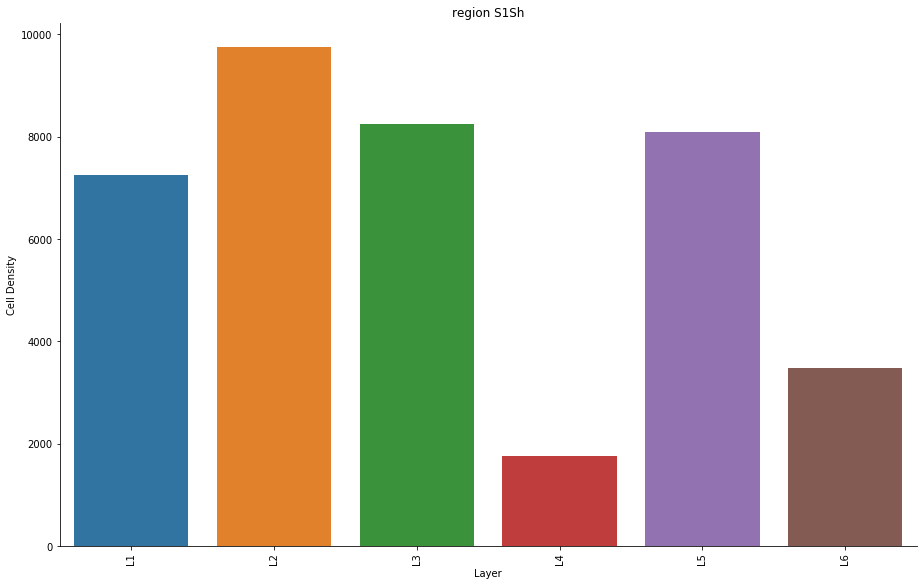

In [6]:
def get_cell_density(adapter, model, **query):
    return adapter.get_cell_density(model, **query)
    
results_section_cell_density =\
    Section(
        title="cell_density",
        narrative="""
        Cell densities are measured in a sample of boxes.
        """,
        data=get_cell_density,
        illustration=MultiPlot(
                mvar="region",
                plotter=Bars(
                    xvar="layer",
                    xlabel="Layer",
                    yvar="cell_density",
                    ylabel="Cell Density")))
parameters =\
    pd.DataFrame(
        [(region, layer) 
        for region in ["S1HL", "S1FL", "S1Tr", "S1Sh"]
        for layer in ["L1", "L2", "L3", "L4", "L5", "L6"]],
        columns=["region", "layer"] )
results_report =\
    results_section_cell_density(
        adapter, model,
        parameters=parameters)

In [7]:
results_report.data.head()

cell_density
dataset region layer              
Model   S1HL   L1      1129.960813
               L2      7316.879534
               L3      1564.328183
               L4      8638.991592
               L5      8744.588671

In [8]:
results_report.illustration

OrderedDict([('S1HL', <dmt.tk.plotting.figure.Figure at 0x121e91410>),
             ('S1FL', <dmt.tk.plotting.figure.Figure at 0x11fdbe0d0>),
             ('S1Tr', <dmt.tk.plotting.figure.Figure at 0x1223b68d0>),
             ('S1Sh', <dmt.tk.plotting.figure.Figure at 0x12262f050>)])

In [9]:
def append_reference_data(
        measurement,
        reference_data={}):
    """
    Append reference data to measurement
    """
    measurement_dict ={
        dataset: measurement.xs(dataset, level="dataset")
        for dataset in measurement.reset_index().dataset.unique()}
    
    def _get_data(dataset):
        try:
            return dataset.data
        except AttributeError:
            return dataset
    
    measurement_dict.update({
        label: _get_data(dataset)
        for label, dataset in reference_data.items()})
    
    return measurement_dict

In [10]:
random_reference_data ={
    dataset: parameters.apply(
        lambda row: row.append(pd.Series({
            "cell_density": np.random.uniform(1., 1.e4),
            "dataset": dataset})),
        axis=1).set_index(["dataset", "region", "layer"])
    for dataset in ["DeFelipe", "Meyer", "Sonja"]}
random_reference_data.keys()

dict_keys(['DeFelipe', 'Meyer', 'Sonja'])

In [11]:
section_refdata =\
    Section(
        narrative="Reference Data",
        data=random_reference_data)

refdata = section_refdata()
print(refdata.narrative)
print(refdata.data.keys())

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/analysis/sectioned.py Logger
ALERT@<2020-03-04 18:11:38>                                                     
Could not fill the template:
'NoneType' object has no attribute 'get_provenance'

Reference Data
dict_keys(['DeFelipe', 'Meyer', 'Sonja'])


In [12]:
chapter_cell_density =\
    Chapter(
        title="Cell Density",
        phenomenon=Phenomenon("Cell Density", "Number of cells in unit volume"),
        AdapterInterface=AdapterInterface,
        abstract="Abstract",
        introduction="Introduction",
        methods="Methods",
        parameters=Section(
            title="Measurement Parameters",
            narrative="Cell density is measured for each layer and region",
            data=parameters),
        measurement=Section(
            title="cell_density",
            narrative="""
            Cell densities are measured in a sample of boxes.
            """,
            data=get_cell_density),
        reference_data=Section(
            title="Reference Data",
            narrative="""
            Reference data for cell densities was obtained from experimental
            measurements.
            """,
            data=random_reference_data),
        results=Section(
            title="Results",
            narrative="""
            Comparision of cell density in $label_circuit_model and
            experimental reference data.
            """,
            data=append_reference_data,
            illustration=MultiPlot(
                mvar="region",
                plotter=Bars(
                    xvar="layer",
                    xlabel="Layer",
                    yvar="cell_density",
                    ylabel="Cell Density",
                    gvar="dataset"))),
        discussion="Discussion")

In [13]:
r = chapter_cell_density.reference_data(adapter, model)

In [14]:
m = chapter_cell_density.measurement(adapter, model, parameters)
m.data.head()

24it [00:00, 798.72it/s]


cell_density
dataset region layer              
Model   S1HL   L1      9798.589646
               L2      9016.153027
               L3      5523.475828
               L4      5102.823116
               L5      3568.598318

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/analysis/sectioned.py Logger
ALERT@<2020-03-04 18:11:38>                                                     
Could not fill the template:
'DataFrame' object has no attribute 'get_provenance'



/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/data/observation/measurement/__init__.py:521: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  for dataset, dataframe in data.items()])


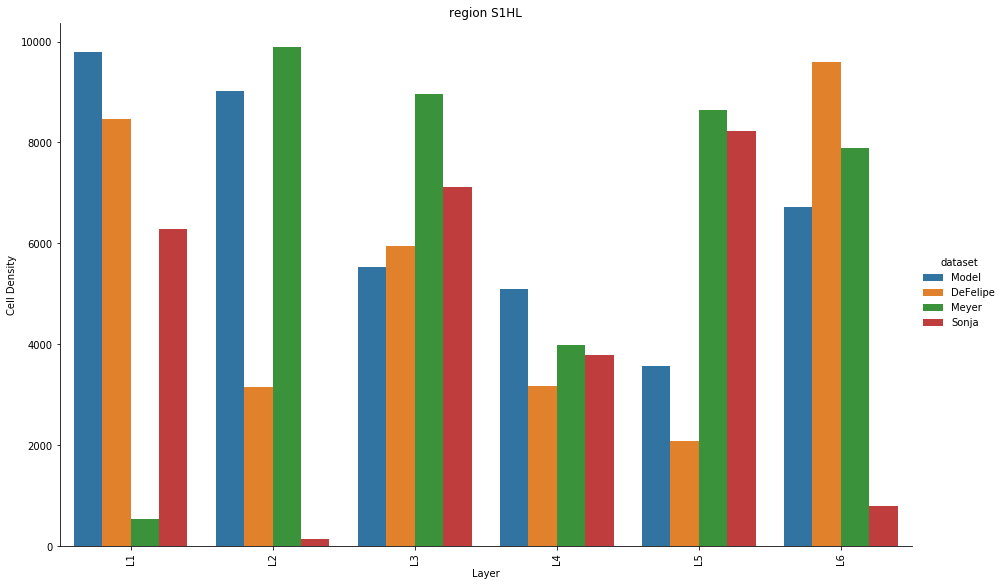

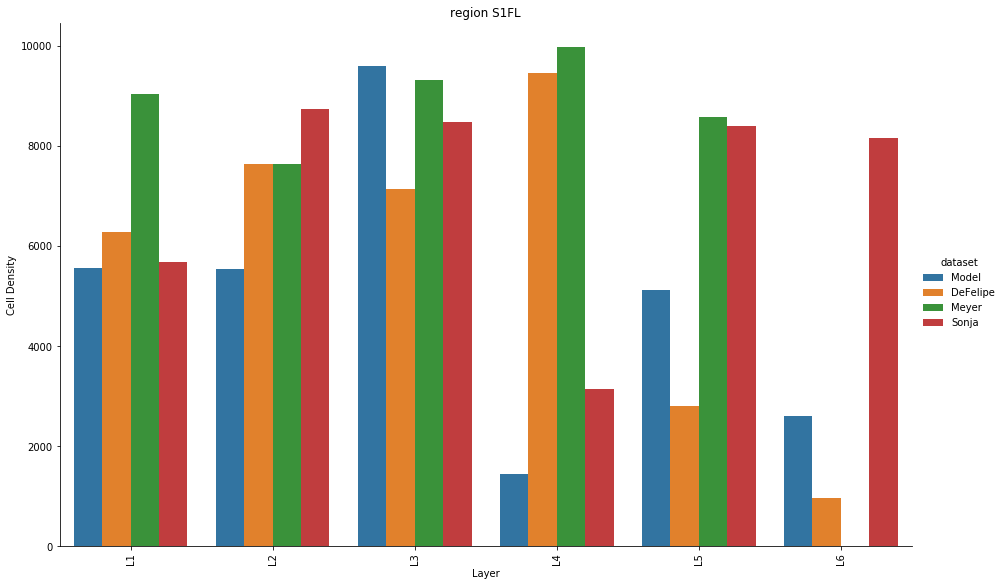

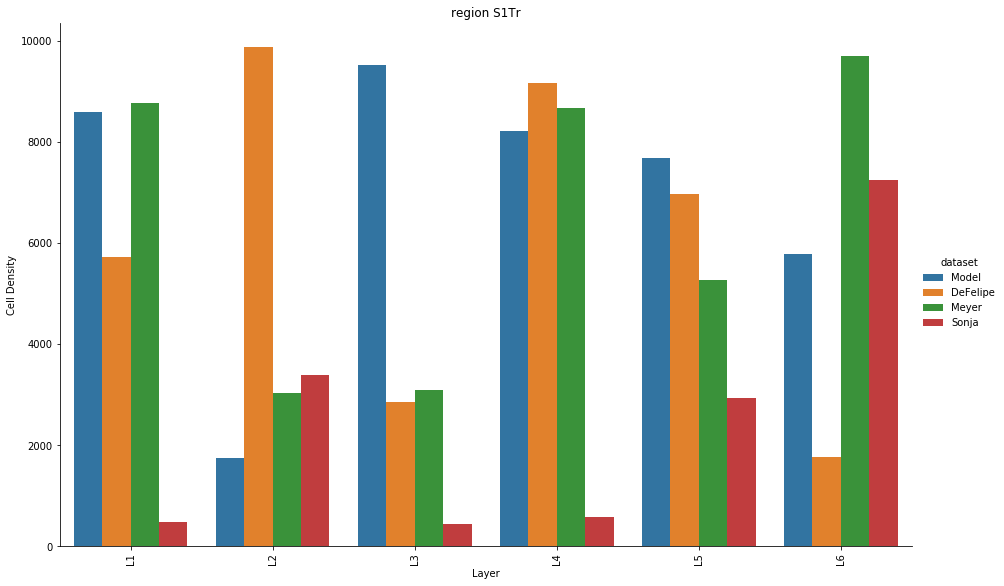

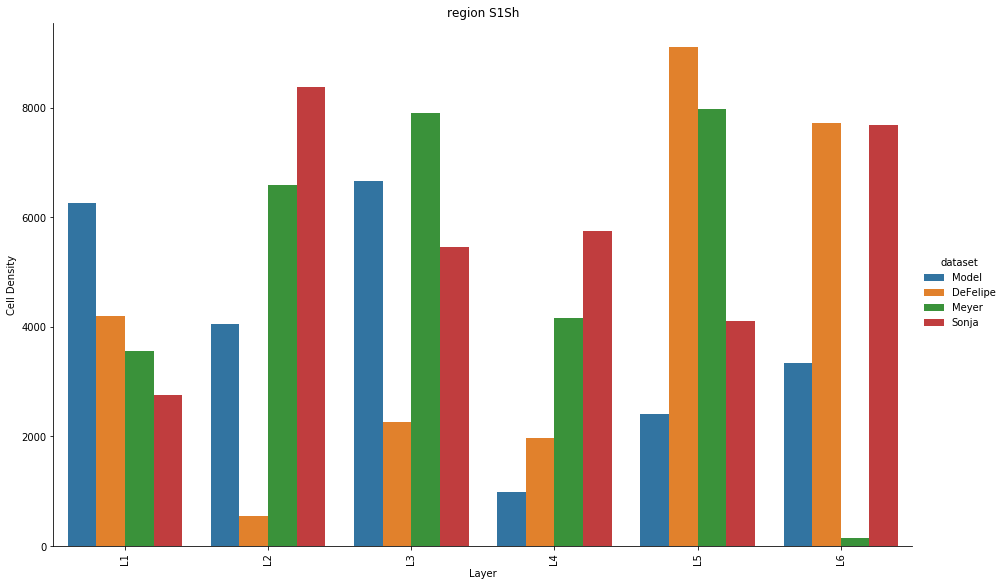

In [15]:
results = chapter_cell_density.results(m.data, r.data)

In [16]:
analysis =\
    StructuredAnalysis(
        author=Author.anonymous,
        AdapterInterface=AdapterInterface,
        chapters=[chapter_cell_density],
        report=CircuitAnalysisReport)

24it [00:00, 1412.76it/s]


/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/analysis/sectioned.py Logger
INFO@<2020-03-04 18:11:38>                                                      

                Could not retrieve citations from reference data of type <class 'dmt.tk.field.record.Record784809225'>.
                

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/dmt/analysis/sectioned.py Logger
ALERT@<2020-03-04 18:11:38>                                                     
Could not fill the template:
'NoneType' object has no attribute 'get_provenance'



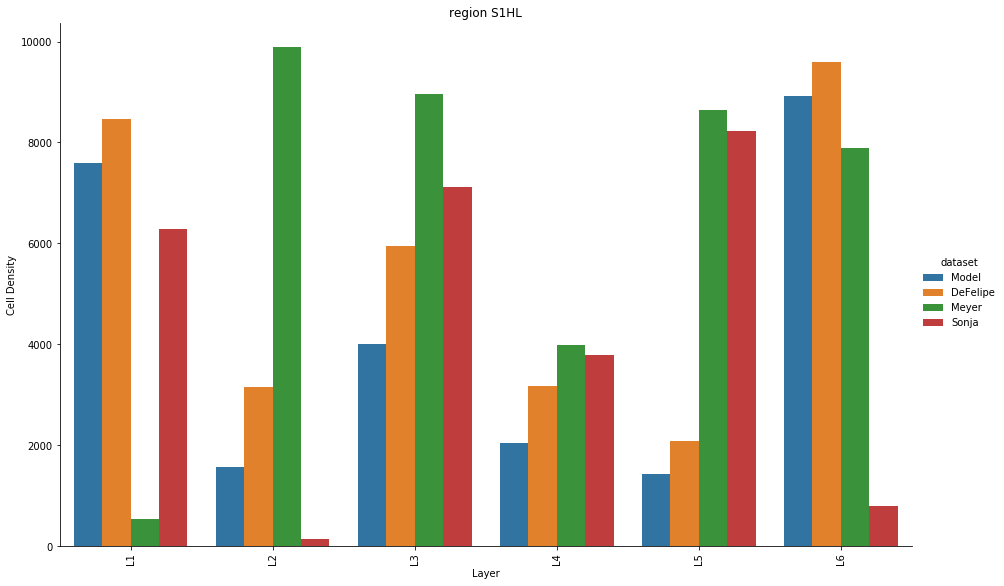

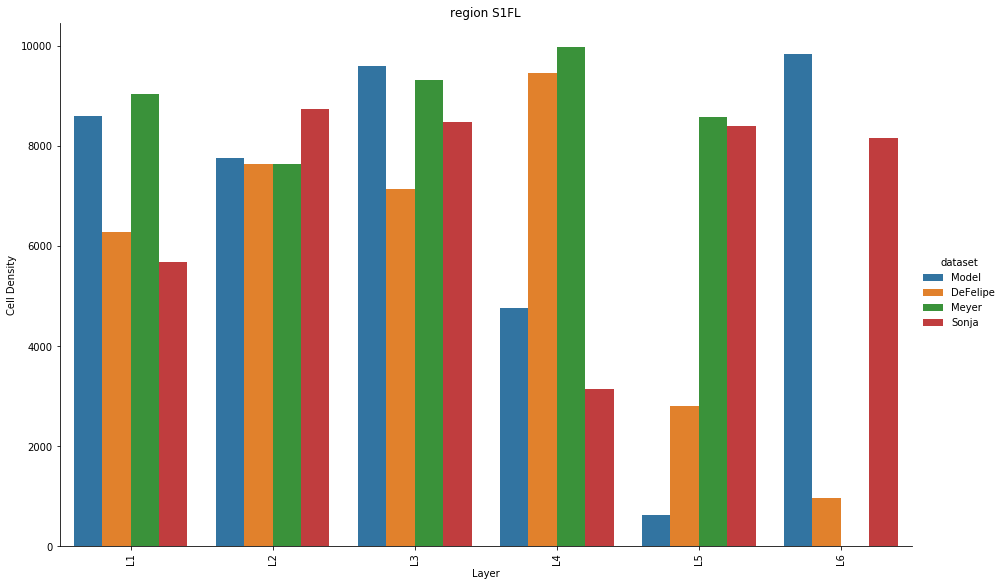

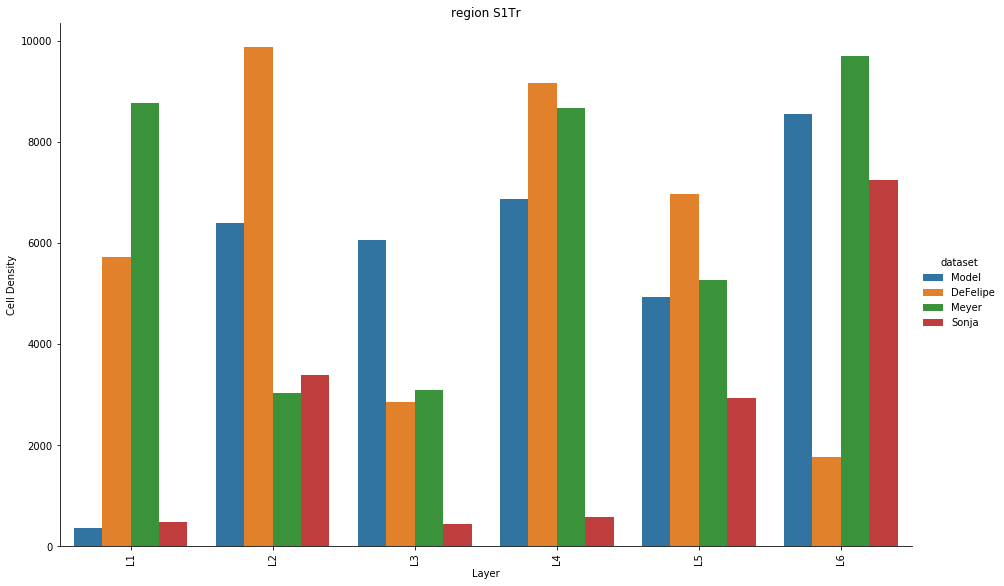

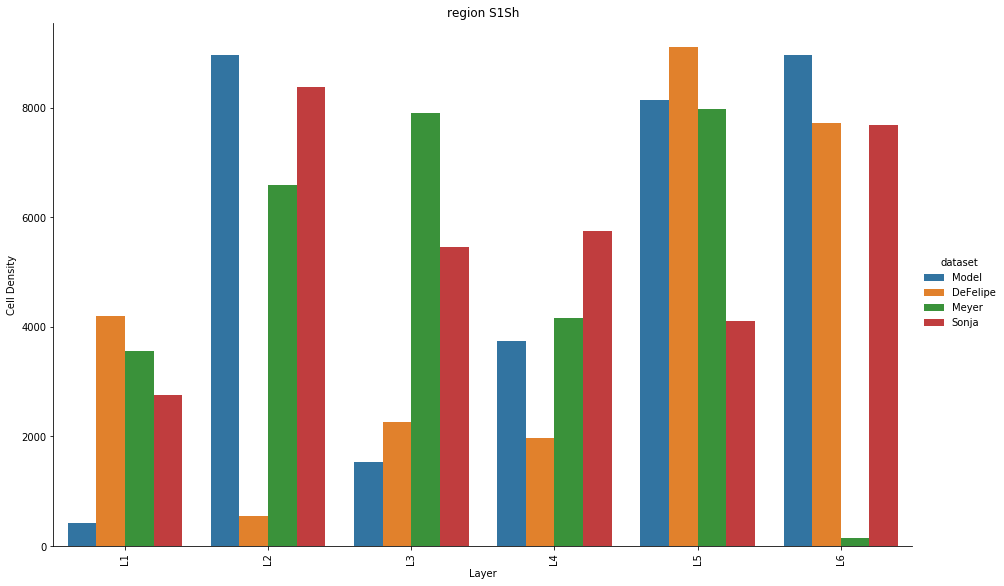

In [17]:
report = analysis(adapter, model)

In [19]:
reporter = CheetahReporter(".")
reporter.post(report["cell_density"])

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-04 18:11:38>                                                      
Post report cell_density at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/notebooks/cell_density/20200304/181206



'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/notebooks/cell_density/20200304/181206'

In [ ]:
report

In [ ]:
cd.reference_data

In [ ]:
cd.discussion.narrative

In [ ]:
cd.discussion.narrative

In [ ]:
analysis.report(
    author=analysis.author,
    phenomenon=cd.phenomenon,
    abstract=cd.abstract,
    introduction=cd.introduction.narrative,
    methods=cd.methods.narrative,
    figures=cd.results.illustration,
    results=cd.results.narrative,
    discussion=cd.discussion.narrative,
    references=cd.references,
    provenance_model=adapter.get_provenance(model))

In [ ]:
cd.abstract